## 1 - Model 1 Logistic Regression

Main goal is to:
* Develop a baseline Logistic Regression model using lab code
* Train the model on the training set and evaluate on the validation set using Accuracy and F1-score as the primary metrics
* Analyze model coefficients to identify influential features (e.g., service, src_bytes, count)

Furthermore, some attack types (like DoS) occur very frequently, while others (like U2R or R2L) are extremely rare. This creates a large imbalance, because the model can easily learn to predict the majority class (“DoS” or “normal”) and still appear accurate, while performing poorly on rare attacks. As part of the solution, class weights will be added. This should automatically penalize mistakes on minority classes more heavily, giving them higher importance during training.


In [2]:
import numpy as np
from pathlib import Path
from joblib import load, dump
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from utils import *

DATA_DIR   = Path("data/processed")
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

X_train, y_train = load_split("train", DATA_DIR)
X_val,   y_val   = load_split("val", DATA_DIR)
X_test,  y_test  = load_split("test", DATA_DIR)

# print("First element in X_train:\n", X_train[:1])
# print("Type of X_train:",type(X_train))

# print("First element in y_train:\n", y_train[:1])
# print("Type of y_train:",type(y_train))

print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))



The shape of X_train is: (100778, 41)
The shape of y_train is: (100778,)
We have m = 100778 training examples


#### Data Visualization

Since the dataset used in this project is high-dimensional, containing numerous numerical features produced through preprocessing and encoding, simple two-dimensional scatterplots would not provide meaningful insights (cf.easily interpretable axes).. Instead, two complementary visualizations were created to explore the data structure more effectively.
* The first plot shows the class distribution in the training set, allowing a quick assessment of whether the dataset is balanced or dominated by specific classes. This is important because class imbalance can bias model learning.
* The second plot presents a two-dimensional Principal Component Analysis (PCA) projection of the feature space. PCA reduces the dimensionality of the data while preserving as much variance as possible, enabling a visual impression of how instances from different classes are spread and whether any natural separation is visible in the space. Together, these plots provide an informative overview of the dataset’s structure before model training.

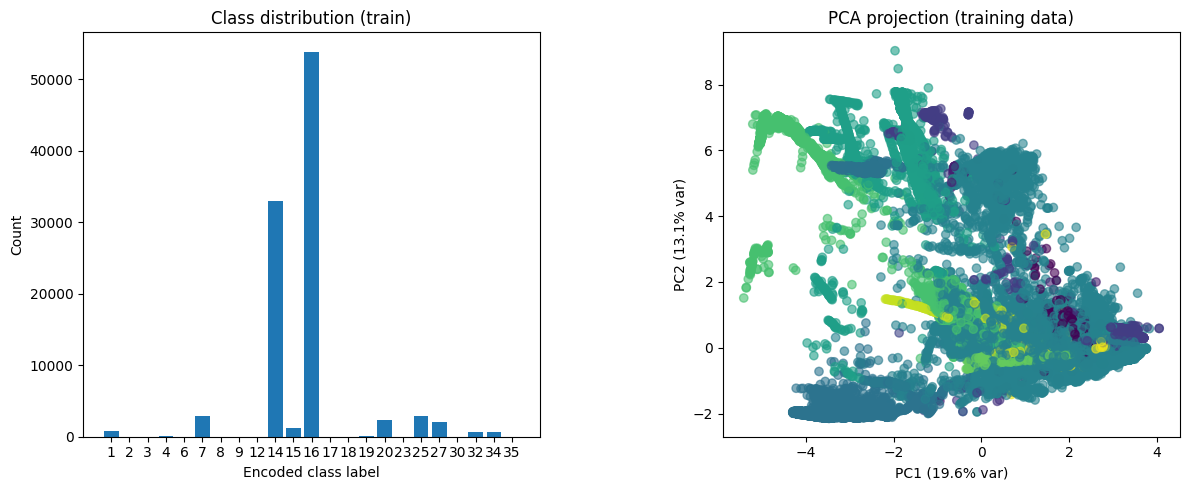

In [7]:
from sklearn.decomposition import PCA


unique, counts = np.unique(y_train, return_counts=True)
pca = PCA(n_components=2, random_state=0)
X_proj = pca.fit_transform(X_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Class imbalance plot
axes[0].bar(unique.astype(str), counts)
axes[0].set_title("Class distribution (train)")
axes[0].set_xlabel("Encoded class label")
axes[0].set_ylabel("Count")

# PCA projection
axes[1].scatter(X_proj[:, 0], X_proj[:, 1], c=y_train, alpha=0.6)
axes[1].set_title("PCA projection (training data)")
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()

The two plots provide a first insight into the structure and characteristics of the training data.
The class distribution plot on the left reveals a clear imbalance: a few classes dominate the dataset while several others contain only a small number of samples. This imbalance is important to consider during model training, as it may bias the classifier toward the majority classes and lead to misleadingly high accuracy. Hence, appropriate measures such as the use of class-weighted loss functions are necessary.

The PCA projection on the right provides a simplified, two-dimensional view of the high-dimensional feature space. Each point represents a sample, positioned based on its similarity to others across all features. Although the projection reveals some general structure and loose grouping, there is considerable overlap between classes. This suggests that the classes are not linearly separable in a low-dimensional space and that the dataset’s informative patterns lie across many features.

Main conclusions:
* The class imbalance is the main risk for performance metrics.
* The feature space is complex, so Logistic Regression will serve as a baseline, not a solution.